In [2]:
!pip install tree-sitter tree-sitter-python tree-sitter-javascript tree-sitter-go --force-reinstall
!pip install scikit-learn

!pip install pandas matplotlib ipywidgets ipympl
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install jupyter-matplotlib

(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
Building jupyterlab assets (production, minimized)
(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
Building jupyterlab assets (production, minimized)


Copy data to local:

In [3]:
!aws s3 cp s3://github-repos-forked-jk4784nr ./data --recursive

download: s3://github-repos-forked-jk4784nr/cpython/Doc/includes/email-alternative.py to data/cpython/Doc/includes/email-alternative.py
download: s3://github-repos-forked-jk4784nr/cpython/Doc/includes/email-mime.py to data/cpython/Doc/includes/email-mime.py
download: s3://github-repos-forked-jk4784nr/cpython/Doc/includes/email-unpack.py to data/cpython/Doc/includes/email-unpack.py
download: s3://github-repos-forked-jk4784nr/cpython/Doc/includes/email-simple.py to data/cpython/Doc/includes/email-simple.py
download: s3://github-repos-forked-jk4784nr/cpython/Android/android.py to data/cpython/Android/android.py
download: s3://github-repos-forked-jk4784nr/cpython/Doc/includes/mp_newtype.py to data/cpython/Doc/includes/mp_newtype.py
download: s3://github-repos-forked-jk4784nr/cpython/Doc/includes/minidom-example.py to data/cpython/Doc/includes/minidom-example.py
download: s3://github-repos-forked-jk4784nr/cpython/Doc/includes/mp_pool.py to data/cpython/Doc/includes/mp_pool.py
download: s3:/

In [4]:
!ls data

cpython  go  strapi  tools


### Load data

In [8]:
import tree_sitter_python
import tree_sitter_go
import tree_sitter_javascript
from tree_sitter import Language, Parser

PY_LANG = Language(tree_sitter_python.language())
TS_LANG = Language(tree_sitter_javascript.language())
GO_LANG = Language(tree_sitter_go.language())

In [32]:
import os

data_path = "./data"
valid_extensions = [".go", ".py", ".ts"]
extension_map_tokenizer = {"go": GO_LANG, "py": PY_LANG, "ts": TS_LANG}
nodes_to_ignore = []

def read_file(file_path):
    try:
        with open(file_path, 'r') as file:
            content = file.read()
        return file_path, content
    except Exception as e:
        return file_path, f"Error reading file: {str(e)}"

def collect_tokens(node, source_code, tokens, depth=0):
    if node.child_count == 0:
        if node.type not in nodes_to_ignore:
            start_byte = node.start_byte
            end_byte = node.end_byte
            token = source_code[start_byte:end_byte].decode("utf-8")
            tokens.append((node.type, token, depth))
    else:
        for child in node.children:
            collect_tokens(child, source_code, tokens, depth+1)

def load_source_code_files(directory):
    file_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if any(file.endswith(ext) for ext in valid_extensions):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)
    return file_paths

def count_file_types_class(files):
    file_types = {}
    for f in files:
        extension = f.split(".")[-1]
        if extension not in file_types:
            file_types[extension] = 0
        file_types[extension] += 1
    return file_types

In [33]:
data_files = load_source_code_files(data_path)
data_files[:10]

['./data/tools/copyright/copyright_test.go',
 './data/tools/copyright/copyright.go',
 './data/tools/go/gcexportdata/gcexportdata.go',
 './data/tools/go/gcexportdata/importer.go',
 './data/tools/go/gcexportdata/example_test.go',
 './data/tools/go/gcexportdata/main.go',
 './data/tools/go/gccgoexportdata/gccgoexportdata_test.go',
 './data/tools/go/gccgoexportdata/gccgoexportdata.go',
 './data/tools/go/loader/loader.go',
 './data/tools/go/loader/loader_test.go']

In [34]:
len(data_files), count_file_types_class(data_files)

(2000, {'go': 1000, 'py': 500, 'ts': 500})

##### Test parser

In [36]:
file = read_file("./data/tools/go/gccgoexportdata/gccgoexportdata.go")

test_go_parser = Parser(GO_LANG)
tree = test_go_parser.parse(bytes(file[1], "utf8"))

tokens = []
collect_tokens(tree.root_node, file[1].encode("utf8"), tokens)

tokens[:10]

[('comment', '// Copyright 2016 The Go Authors. All rights reserved.', 1),
 ('comment', '// Use of this source code is governed by a BSD-style', 1),
 ('comment', '// license that can be found in the LICENSE file.', 1),
 ('comment',
  '// Package gccgoexportdata provides functions for reading export data',
  1),
 ('comment',
  '// files containing type information produced by the gccgo compiler.',
  1),
 ('comment', '//', 1),
 ('comment',
  '// This package is a stop-gap until such time as gccgo uses the same',
  1),
 ('comment',
  '// export data format as gc; see Go issue 17573. Once that occurs, this',
  1),
 ('comment', '// package will be deprecated and eventually deleted.', 1),
 ('package', 'package', 2)]

##### Vectorizer

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from functools import lru_cache

@lru_cache(maxsize=None)
def tokenizer(file):
    file_extension = file.split(".")[-1]
    file_content = read_file(file)[1]

    lang = extension_map_tokenizer[file_extension]
    parser = Parser(lang)
    tree = parser.parse(bytes(file_content, "utf8"))
    
    tokens = []
    collect_tokens(tree.root_node, file_content.encode("utf8"), tokens)

    node_types = [x[0] for x in tokens]
    return node_types

vectorizer = TfidfVectorizer(tokenizer=tokenizer)

In [53]:
features = vectorizer.fit_transform(data_files)
print(f"n_samples: {features.shape[0]}, n_features: {features.shape[1]}")

n_samples: 2000, n_features: 147


In [55]:
vectorizer.get_feature_names_out()

array(['\n', '!', '!=', '!==', '"', '${', '%', '%=', '&', '&&', '&=',
       '&^', '&^=', "'", '(', ')', '*', '**', '*=', '+', '++', '+=', ',',
       '-', '--', '-=', '.', '...', '/', '/=', '/>', ':', ':=', ';', '<',
       '<-', '<<', '<<=', '<=', '=', '==', '===', '=>', '>', '>=', '>>',
       '>>=', '?', '??', 'ERROR', '[', ']', '^', '^=', '`', 'as', 'async',
       'await', 'blank_identifier', 'break', 'case', 'catch', 'chan',
       'class', 'comment', 'const', 'continue', 'default', 'defer',
       'delete', 'else', 'escape_sequence', 'export', 'extends',
       'fallthrough', 'false', 'field_identifier', 'finally',
       'float_literal', 'for', 'from', 'func', 'function', 'get', 'go',
       'goto', 'identifier', 'if', 'imaginary_literal', 'import', 'in',
       'instanceof', 'int_literal', 'integer', 'interface', 'iota',
       'jsx_text', 'label_name', 'let', 'map', 'new', 'nil', 'null',
       'number', 'of', 'optional_chain', 'or', 'package',
       'package_identifier', '

### Apply K-Means

In [156]:
from sklearn.cluster import KMeans

k = 3
kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
clusters = kmeans.fit_predict(features)

cluster_results = {}
for i in range(k):
    if i not in cluster_results:
        cluster_results[i] = []
        
    cluster_results[i].extend([data_files[j] for j in range(len(data_files)) if clusters[j] == i])

for k,v in cluster_results.items():
    print(f"cluster: {k}, result: {count_file_types_class(v)}")

cluster: 0, result: {'ts': 462}
cluster: 1, result: {'go': 995, 'ts': 1}
cluster: 2, result: {'go': 5, 'py': 500, 'ts': 37}


### Visualization

In [173]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
reduced_data = pca.fit_transform(features.toarray())
print(f"n_samples: {reduced_data.shape[0]}, n_features: {reduced_data.shape[1]}")

n_samples: 2000, n_features: 3


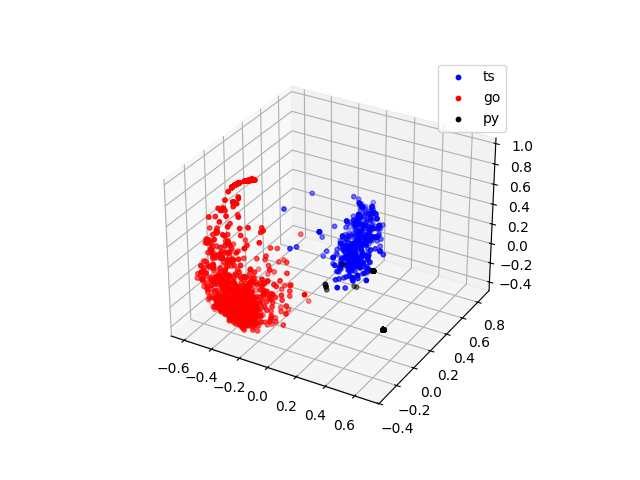

In [182]:
%matplotlib widget

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

colors = ["blue", "red", "black"]
cluster_names = ["ts", "go", "py"]
for i in range(len(colors)):
    ax.scatter(reduced_data[kmeans.labels_ == i, 0],
               reduced_data[kmeans.labels_ == i, 1],
               reduced_data[kmeans.labels_ == i, 2],
               color=colors[i],
               s=10,
               label=cluster_names[i]
              )

ax.view_init(azim=0, elev=0)
plt.legend()
plt.show()

### Test

In [157]:
data_test = "./data/test"
test_files = load_source_code_files(data_test)

len(test_files), count_file_types_class(test_files)

(3, {'py': 1, 'go': 2})

In [158]:
test_features = vectorizer.transform(test_files)
test_features.shape

(3, 147)

In [159]:
test_clusters = kmeans.predict(test_features)
test_clusters

array([2, 1, 1], dtype=int32)